In [1]:
import numpy as np
import pandas as pd



import gc


print('loading prior')
priors = pd.read_csv('./data/order_products__prior.csv')

train = pd.read_csv('./data/train_new.csv')
train_eval = pd.read_csv('./data/train_eval.csv')

print('loading orders')
orders = pd.read_csv('./data/orders.csv')


###
# some memory measures for kaggle kernel
print('optimize memory')
orders.order_dow = orders.order_dow.astype(np.int8)
orders.order_hour_of_day = orders.order_hour_of_day.astype(np.int8)
orders.order_number = orders.order_number.astype(np.int16)
orders.order_id = orders.order_id.astype(np.int32)
orders.user_id = orders.user_id.astype(np.int32)
orders.days_since_prior_order = orders.days_since_prior_order.astype(np.float32)


train.reordered = train.reordered.astype(np.int8)
train.add_to_cart_order = train.add_to_cart_order.astype(np.int16)

train_eval.reordered = train.reordered.astype(np.int8)
train_eval.add_to_cart_order = train.add_to_cart_order.astype(np.int16)

priors.order_id = priors.order_id.astype(np.int32)
priors.add_to_cart_order = priors.add_to_cart_order.astype(np.int16)
priors.reordered = priors.reordered.astype(np.int8)
priors.product_id = priors.product_id.astype(np.int32)

gc.collect()


loading prior
loading orders
optimize memory


0

## Prepare the Y Variable

In [2]:
orders.set_index('order_id', inplace = True, drop = False)
train.set_index('order_id', inplace = True, drop = False)
train_eval.set_index('order_id', inplace = True, drop = False)




train = train.join(orders, on = 'order_id', rsuffix = '_')
train.drop('order_id_', inplace = True, axis = 1)

train_eval = train_eval.join(orders, on = 'order_id', rsuffix = '_')
train_eval.drop('order_id_', inplace = True, axis = 1)



train.reset_index(inplace=True, drop=True)
train_eval.reset_index(inplace=True, drop=True)
orders.reset_index(inplace=True, drop=True)


y_df = pd.DataFrame()
y_df['y'] = train.groupby('user_id')['product_id'].agg('count')

y_df.reset_index(inplace = True, drop = False)

y_df.head()

,user_id,y
0,1,11
1,2,31
2,5,9
3,7,9
4,8,18


In [3]:
y_eval_df = pd.DataFrame()
y_eval_df['y'] = train_eval.groupby('user_id')['product_id'].agg('count')

y_eval_df.reset_index(inplace = True, drop = False)

y_eval_df.head()

,user_id,y
0,9,22
1,10,4
2,14,11
3,23,12
4,30,1


In [4]:
print('Join orders with prior')
orders.set_index('order_id', inplace = True, drop = False)
priors.set_index('order_id', inplace = True, drop = False)

priors = priors.join(orders, on = 'order_id', rsuffix = '_')
priors.drop('order_id_', inplace = True, axis = 1)

priors.reset_index(inplace=True, drop=True)
orders.reset_index(inplace=True, drop=True)


print('Prepare prior for featrues')

prior_subset = pd.DataFrame()

prior_subset['p_count']    = priors.groupby(['user_id','order_id','order_number'], group_keys = False)['product_id'].agg('count')
prior_subset['rorder_sum'] = priors.groupby(['user_id','order_id','order_number'], group_keys = False)['reordered'].agg('sum')
prior_subset['rorder_rate'] = prior_subset['rorder_sum'] / prior_subset['p_count']




prior_subset.reset_index(drop = False, inplace=True)
prior_subset.sort_values(by = ['user_id','order_number'], inplace = True, ascending = [True, True], axis = 0)
prior_subset.drop('order_id', inplace = True, axis = 1)


prior_subset.reset_index(inplace = True, drop = True)


Join orders with prior
Prepare prior for featrues


In [5]:
prior_subset.head()

,user_id,order_number,p_count,rorder_sum,rorder_rate
0,1,1,5,0.0,0.000
1,1,2,6,3.0,0.500
2,1,3,5,3.0,0.600
3,1,4,5,5.0,1.000
4,1,5,8,5.0,0.625


## Run timeseries_features.py

In [6]:
ts_features = pd.read_csv('./features/ts_features.csv')
ts_features.head()

,rorder_sum__length,rorder_sum__standard_deviation,rorder_sum__median,rorder_sum__sum_values,rorder_sum__maximum,rorder_sum__mean,rorder_sum__variance,rorder_sum__minimum,rorder_rate__median,rorder_rate__standard_deviation,...,rorder_rate__sum_values,rorder_rate__mean,p_count__minimum,p_count__median,p_count__variance,p_count__mean,p_count__maximum,p_count__standard_deviation,p_count__sum_values,p_count__length
0,10.0,1.700000,4.5,41.0,6.0,4.100000,2.890000,0.0,0.666667,0.301249,...,7.058333,0.705833,4.0,5.5,2.090000,5.900000,9.0,1.445683,59.0,10.0
1,14.0,5.107517,8.5,93.0,14.0,6.642857,26.086735,0.0,0.566964,0.304302,...,6.271453,0.447961,5.0,13.5,30.352041,13.928571,26.0,5.509269,195.0,14.0
2,12.0,2.253084,5.0,55.0,7.0,4.583333,5.076389,0.0,0.763889,0.319517,...,7.905808,0.658817,5.0,7.0,4.055556,7.333333,11.0,2.013841,88.0,12.0
3,5.0,0.400000,0.0,1.0,1.0,0.200000,0.160000,0.0,0.000000,0.057143,...,0.142857,0.028571,2.0,3.0,3.440000,3.600000,7.0,1.854724,18.0,5.0
4,4.0,2.958040,3.0,14.0,8.0,3.500000,8.750000,0.0,0.422222,0.240370,...,1.511111,0.377778,5.0,10.0,7.187500,9.250000,12.0,2.680951,37.0,4.0


In [7]:
ts_features['user_id'] = prior_subset['user_id'].unique()
ts_features.head(10)


,rorder_sum__length,rorder_sum__standard_deviation,rorder_sum__median,rorder_sum__sum_values,rorder_sum__maximum,rorder_sum__mean,rorder_sum__variance,rorder_sum__minimum,rorder_rate__median,rorder_rate__standard_deviation,...,rorder_rate__mean,p_count__minimum,p_count__median,p_count__variance,p_count__mean,p_count__maximum,p_count__standard_deviation,p_count__sum_values,p_count__length,user_id
0,10.0,1.700000,4.5,41.0,6.0,4.100000,2.890000,0.0,0.666667,0.301249,...,0.705833,4.0,5.5,2.090000,5.900000,9.0,1.445683,59.0,10.0,1
1,14.0,5.107517,8.5,93.0,14.0,6.642857,26.086735,0.0,0.566964,0.304302,...,0.447961,5.0,13.5,30.352041,13.928571,26.0,5.509269,195.0,14.0,2
2,12.0,2.253084,5.0,55.0,7.0,4.583333,5.076389,0.0,0.763889,0.319517,...,0.658817,5.0,7.0,4.055556,7.333333,11.0,2.013841,88.0,12.0,3
3,5.0,0.400000,0.0,1.0,1.0,0.200000,0.160000,0.0,0.000000,0.057143,...,0.028571,2.0,3.0,3.440000,3.600000,7.0,1.854724,18.0,5.0,4
4,4.0,2.958040,3.0,14.0,8.0,3.500000,8.750000,0.0,0.422222,0.240370,...,0.377778,5.0,10.0,7.187500,9.250000,12.0,2.680951,37.0,4.0,5
5,3.0,0.942809,0.0,2.0,2.0,0.666667,0.888889,0.0,0.000000,0.134687,...,0.095238,3.0,4.0,2.888889,4.666667,7.0,1.699673,14.0,3.0,6
6,20.0,4.493328,6.5,138.0,20.0,6.900000,20.190000,0.0,0.894444,0.315570,...,0.754255,1.0,10.0,33.010000,10.300000,24.0,5.745433,206.0,20.0,7
7,3.0,3.299832,5.0,13.0,8.0,4.333333,10.888889,0.0,0.384615,0.224720,...,0.305983,13.0,15.0,11.555556,16.333333,21.0,3.399346,49.0,3.0,8
8,3.0,5.887841,4.0,18.0,14.0,6.000000,34.666667,0.0,0.363636,0.180602,...,0.254545,11.0,30.0,106.888889,25.333333,35.0,10.338708,76.0,3.0,9
9,5.0,10.571660,5.0,49.0,29.0,9.800000,111.760000,0.0,0.151515,0.369415,...,0.325665,5.0,30.0,176.240000,28.600000,46.0,13.275541,143.0,5.0,10


In [8]:


y_df = y_df.join(ts_features, on='user_id', rsuffix='_')
y_df.drop(['user_id_'], inplace = True, axis = 1)


y_eval_df = y_eval_df.join(ts_features, on='user_id', rsuffix='_')
y_eval_df.drop(['user_id_'], inplace = True, axis = 1)

## Replace na with 0
nan_rows = y_df[y_df.isnull().T.any().T]
y_df.fillna(value = 0, inplace = True)

## Replace na with 0
nan_rows = y_eval_df[y_eval_df.isnull().T.any().T]
y_eval_df.fillna(value = 0, inplace = True)



y_df.to_csv('./features/regression/y_df.csv', index = False)
y_eval_df.to_csv('./features/regression/y_eval_df.csv', index = False)



In [9]:
y_df.head()

,user_id,y,rorder_sum__length,rorder_sum__standard_deviation,rorder_sum__median,rorder_sum__sum_values,rorder_sum__maximum,rorder_sum__mean,rorder_sum__variance,rorder_sum__minimum,...,rorder_rate__sum_values,rorder_rate__mean,p_count__minimum,p_count__median,p_count__variance,p_count__mean,p_count__maximum,p_count__standard_deviation,p_count__sum_values,p_count__length
0,1,11,14.0,5.107517,8.5,93.0,14.0,6.642857,26.086735,0.0,...,6.271453,0.447961,5.0,13.5,30.352041,13.928571,26.0,5.509269,195.0,14.0
1,2,31,12.0,2.253084,5.0,55.0,7.0,4.583333,5.076389,0.0,...,7.905808,0.658817,5.0,7.0,4.055556,7.333333,11.0,2.013841,88.0,12.0
2,5,9,3.0,0.942809,0.0,2.0,2.0,0.666667,0.888889,0.0,...,0.285714,0.095238,3.0,4.0,2.888889,4.666667,7.0,1.699673,14.0,3.0
3,7,9,3.0,3.299832,5.0,13.0,8.0,4.333333,10.888889,0.0,...,0.917949,0.305983,13.0,15.0,11.555556,16.333333,21.0,3.399346,49.0,3.0
4,8,18,3.0,5.887841,4.0,18.0,14.0,6.000000,34.666667,0.0,...,0.763636,0.254545,11.0,30.0,106.888889,25.333333,35.0,10.338708,76.0,3.0


In [12]:
y_eval_df.head()

,user_id,y,rorder_sum__length,rorder_sum__standard_deviation,rorder_sum__median,rorder_sum__sum_values,rorder_sum__maximum,rorder_sum__mean,rorder_sum__variance,rorder_sum__minimum,...,rorder_rate__sum_values,rorder_rate__mean,p_count__minimum,p_count__median,p_count__variance,p_count__mean,p_count__maximum,p_count__standard_deviation,p_count__sum_values,p_count__length
0,9,22,5.0,10.571660,5.0,49.0,29.0,9.800000,111.760000,0.0,...,1.628327,0.325665,5.0,30.0,176.240000,28.600000,46.0,13.275541,143.0,5.0
1,10,4,7.0,3.574285,3.0,33.0,12.0,4.714286,12.775510,0.0,...,2.415261,0.345037,10.0,13.0,5.102041,13.428571,17.0,2.258770,94.0,7.0
2,14,11,22.0,1.426578,2.5,59.0,6.0,2.681818,2.035124,0.0,...,18.316667,0.832576,1.0,3.0,1.561983,3.272727,6.0,1.249793,72.0,22.0
3,23,12,18.0,0.993808,1.0,20.0,3.0,1.111111,0.987654,0.0,...,9.083333,0.504630,1.0,2.0,0.987654,2.111111,4.0,0.993808,38.0,18.0
4,30,1,20.0,6.568676,2.0,109.0,25.0,5.450000,43.147500,0.0,...,5.632910,0.281645,2.0,10.5,131.747500,14.950000,35.0,11.478131,299.0,20.0


## Build the model

In [64]:
import lightgbm as lgb

train   = lgb.Dataset(y_df.ix[:,2:], y_df.ix[:,1])
evalset = lgb.Dataset(y_eval_df.ix[:,2:], y_eval_df.ix[:,1])

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'poisson',
    'metric': {'poisson', 'mse'},
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.9,
    'bagging_freq': 10,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                train,
                num_boost_round=20,
                valid_sets=evalset,
                early_stopping_rounds=5)

print('Save model...')
# save model to file
gbm.save_model('./models/gbm_reg_model.txt')




Start training...
[1]	valid_0's poisson: -14.2908	valid_0's l2: 62.3424
Train until valid scores didn't improve in 5 rounds.
[2]	valid_0's poisson: -14.2908	valid_0's l2: 62.3425
[3]	valid_0's poisson: -14.2908	valid_0's l2: 62.3426
[4]	valid_0's poisson: -14.2908	valid_0's l2: 62.3425
[5]	valid_0's poisson: -14.2908	valid_0's l2: 62.3423
[6]	valid_0's poisson: -14.2908	valid_0's l2: 62.3419
[7]	valid_0's poisson: -14.2908	valid_0's l2: 62.3417
[8]	valid_0's poisson: -14.2909	valid_0's l2: 62.3414
[9]	valid_0's poisson: -14.2909	valid_0's l2: 62.3412
[10]	valid_0's poisson: -14.2909	valid_0's l2: 62.341
[11]	valid_0's poisson: -14.2908	valid_0's l2: 62.342
[12]	valid_0's poisson: -14.2908	valid_0's l2: 62.3422
[13]	valid_0's poisson: -14.2908	valid_0's l2: 62.3432
[14]	valid_0's poisson: -14.2907	valid_0's l2: 62.344
[15]	valid_0's poisson: -14.2907	valid_0's l2: 62.3442
Early stopping, best iteration is:
[10]	valid_0's poisson: -14.2909	valid_0's l2: 62.341
Save model...


In [65]:
from sklearn.metrics import mean_squared_error
print('Start predicting...')
# predict
y_pred = gbm.predict(y_eval_df.ix[:,2:], num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_eval_df.ix[:,1], y_pred) ** 0.5)

Start predicting...
('The rmse of prediction is:', 7.895634448415433)


In [48]:
y_pred

array([ 10.55256921,  10.55560095,  10.55560095, ...,  10.55560095,
        10.55256921,  10.55256921])

In [30]:
# feature importances

for i,(n,s) in enumerate(zip(train.feature_name, list(gbm.feature_importance()))):
    print i,'  :',n,s


0   : rorder_sum__length 0
1   : rorder_sum__standard_deviation 0
2   : rorder_sum__median 2
3   : rorder_sum__sum_values 1
4   : rorder_sum__maximum 0
5   : rorder_sum__mean 0
6   : rorder_sum__variance 2
7   : rorder_sum__minimum 0
8   : rorder_rate__median 2
9   : rorder_rate__standard_deviation 4
10   : rorder_rate__variance 0
11   : rorder_rate__length 0
12   : rorder_rate__maximum 3
13   : rorder_rate__minimum 0
14   : rorder_rate__sum_values 0
15   : rorder_rate__mean 2
16   : p_count__minimum 1
17   : p_count__median 2
18   : p_count__variance 3
19   : p_count__mean 4
20   : p_count__maximum 3
21   : p_count__standard_deviation 0
22   : p_count__sum_values 1
23   : p_count__length 0


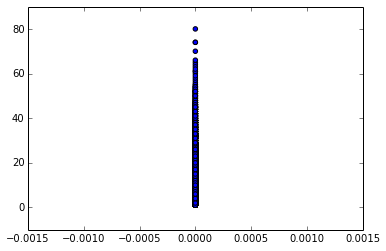

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.scatter(y_eval_df.ix[:,9], y_eval_df.ix[:,1])

In [35]:
y_eval_df.ix[:,8]

0        111.760000
1         12.775510
2          2.035124
3          0.987654
4         43.147500
5         76.246914
6          4.222222
7          0.187500
8          0.437500
9          5.555556
10         0.222222
11        18.854167
12         4.209184
13        52.499055
14         1.888889
15         1.551020
16        20.170132
17         1.714286
18         4.472222
19         5.000000
20         0.122449
21        16.763341
22         0.960000
23         0.800000
24        13.805556
25         1.265306
26        17.187500
27         2.000000
28         2.000000
29        11.289941
            ...    
32772      2.222222
32773     22.183594
32774     15.017751
32775     10.331066
32776      8.609375
32777      4.560000
32778     16.240000
32779      8.328889
32780     21.383492
32781     14.277344
32782      0.222222
32783      3.358025
32784      0.222222
32785      1.687500
32786      5.555556
32787      6.693878
32788      9.408163
32789      2.666667
32790      0.222222


In [26]:
from sklearn.ensemble import RandomForestRegressor


    
forest = RandomForestRegressor(n_estimators = 200, max_features = 'sqrt' ,random_state = 100, n_jobs = -1, verbose = 1, oob_score = True)
forest.fit(X.values, Y.values)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=True, random_state=100,
           verbose=1, warm_start=False)

In [27]:
oob_p = forest.oob_prediction_
oob_p = np.round(oob_p, 0)


np.mean(np.abs(oob_p - Y.values))


6.2815856595567388

In [23]:
oob_p

array([ 12.,  12.,  17., ...,  13.,   9.,  10.])

In [ ]:


from sklearn.ensemble import RandomForestRegressor

oob_scores = []
r2_scores = []
n_trees = range(100,200,10)

for ne in n_trees:
    
    print "Starting ", ne
    forest = RandomForestRegressor(n_estimators = 200, max_features = 2 ,random_state = 100, n_jobs = -1, verbose = 0, oob_score = True)
    forest.fit(X.values, Y.values)
    oob_p = forest.oob_prediction_
    y_p = np.round(oob_p,0)
    oob_scores.append(sum(abs(y_p - Y.values)) / ( 1.0 * len(y_p)))
    r2_scores.append(forest.score(X.values, Y.values))



In [ ]:
%matplotlib inline


import  matplotlib.pyplot as plt

plt.scatter(n_trees, oob_scores)


In [ ]:
plt.scatter(n_trees, r2_scores)



In [ ]:
X_eval = y_eval_df.ix[:,2:]
Y_eval = y_eval_df.ix[:,1]

## Dummy variables
X_eval = pd.get_dummies(X_eval, prefix = ['o1_order_dow','o2_order_dow','o3_order_dow'
                                             ,'o1_order_hr','o2_order_hr','o3_order_hr'],
                   columns = ['o1_order_dow','o2_order_dow','o3_order_dow'
                                             ,'o1_order_hr','o2_order_hr','o3_order_hr'])

#forest.score(X_eval.values, Y_eval.values)

In [ ]:
y_p = forest.predict(X_eval.values)
y_p = np.round(y_p,0)

np.mean(np.abs(Y_eval.values - y_p))


In [ ]:
Y_eval.values